In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from importlib.metadata import version

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

cpu
torch version: 2.4.0+cu124
tiktoken version: 0.7.0


本章介绍了数据准备和采样，以使输入数据“准备好”用于LLM

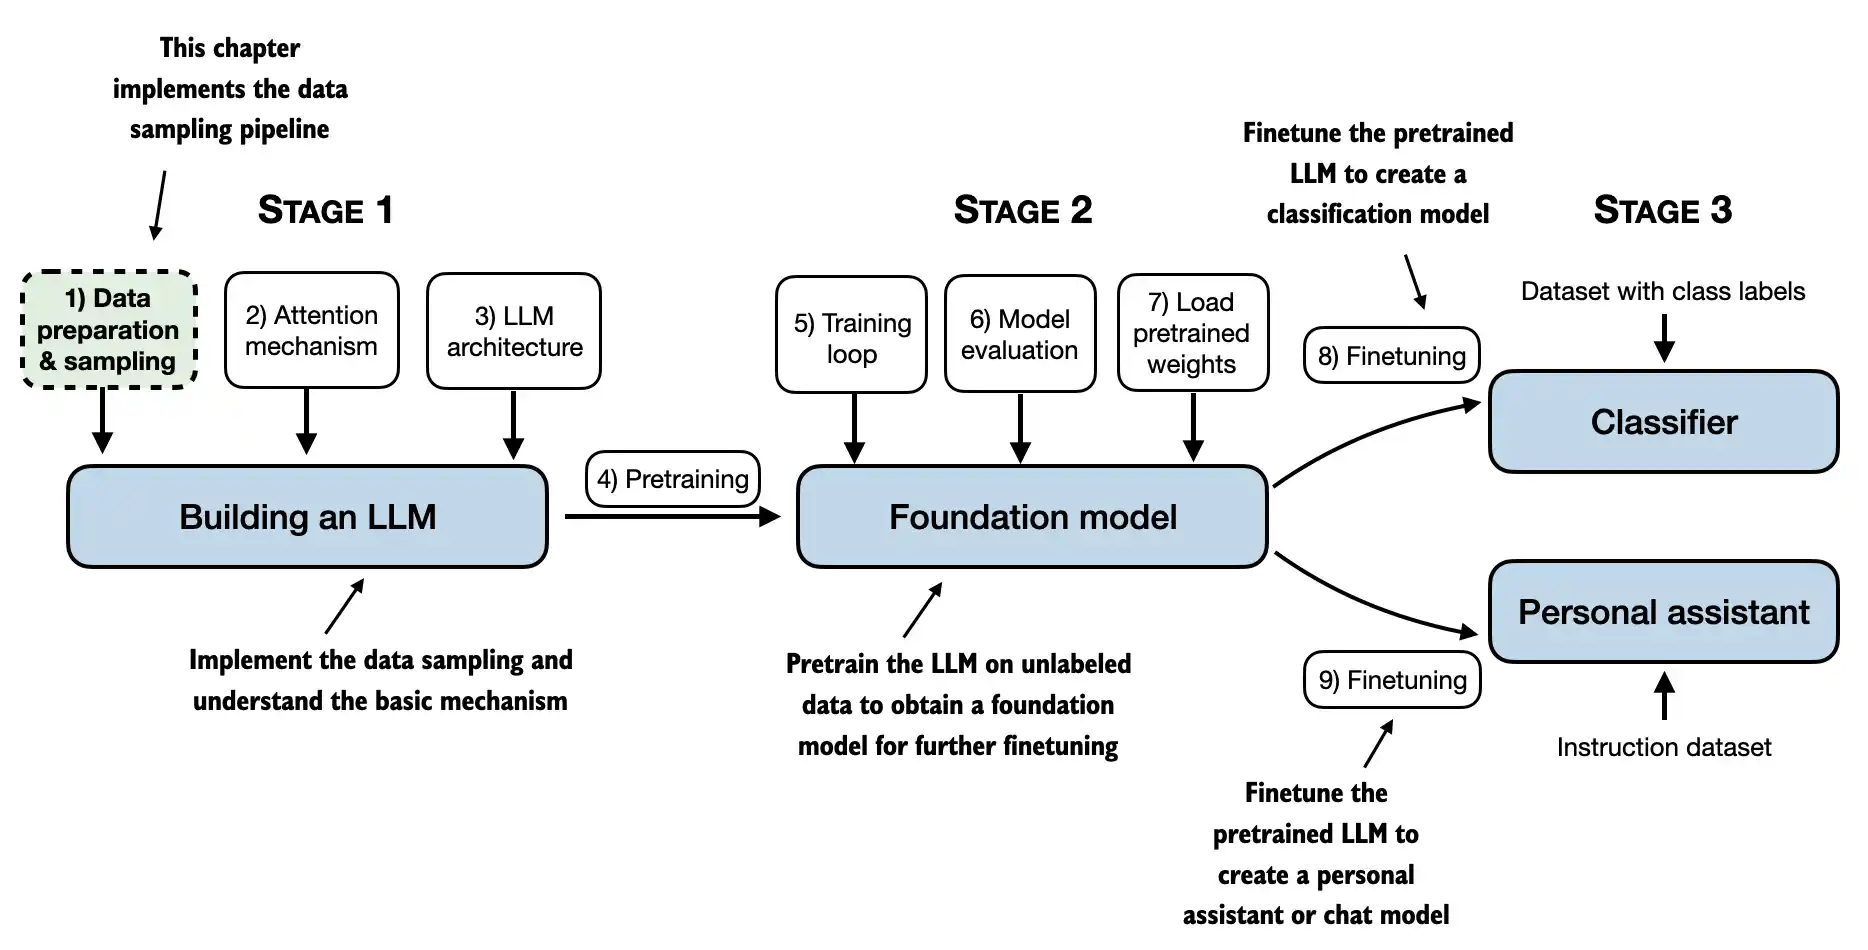

In [ ]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
print(chars)
vocab_size = len(chars)
print(vocab_size)

In [ ]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])
encoded = encode('hello')
print(encoded)  # 输出: [7, 4, 11, 11, 14]

decoded = decode(encoded)
print(decoded)  # 输出: 'hello'

[63, 60, 67, 67, 70]
hello


代码解释
字符集定义（未显示）:
假设 chars 是一个包含所有可能字符的字符串。例如，chars = 'abcdefghijklmnopqrstuvwxyz'。

生成字符到整数的映射（字典）:

python
Copy code
string_to_int = { ch:i for i,ch in enumerate(chars) }
这段代码使用字典推导式和 enumerate 函数，将 chars 中的每个字符映射到一个唯一的整数。enumerate(chars) 会生成一个形如 (index, char) 的元组序列。

例如，假设 chars = 'abc'，那么生成的字典会是：

python
Copy code
string_to_int = { 'a': 0, 'b': 1, 'c': 2 }
生成整数到字符的映射（字典）:

python
Copy code
int_to_string = { i:ch for i,ch in enumerate(chars) }
这段代码也使用字典推导式和 enumerate 函数，但这次将整数映射到字符，生成的字典是 string_to_int 的反向映射。

继续上面的例子：

python
Copy code
int_to_string = { 0: 'a', 1: 'b', 2: 'c' }
编码函数:

python
Copy code
encode = lambda s: [string_to_int[c] for c in s]
这段代码定义了一个匿名函数 encode，将字符串 s 转换为整数列表。它通过查找 string_to_int 字典中每个字符对应的整数来实现这一点。

例如：

python
Copy code
encode('abc')  # 输出: [0, 1, 2]
encode('cab')  # 输出: [2, 0, 1]
解码函数:

python
Copy code
decode = lambda l: ''.join([int_to_string[i] for i in l])
这段代码定义了一个匿名函数 decode，将整数列表 l 转换回字符串。它通过查找 int_to_string 字典中每个整数对应的字符，并将这些字符连接成一个字符串。

### 2.2 文本标记化

对文本进行标记，这意味着将文本分解为更小的单元，例如单个单词和标点符号

In [3]:
with open('the-verdict.txt','r',encoding='utf-8') as f:
    raw_text = f.read()
print("Total number of character:",len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [4]:
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


- 结果是单个单词、空格和标点符号的列表：
- ['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']

\s让我们修改空格（ ）和逗号以及句点（[,.]）的正则表达式拆分：

In [5]:
result = re.split(r'([,.]|\s)',text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


我们可以看到，单词和标点符号现在是单独的列表条目

In [6]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


得到的无空格输出如上所示

让我们进一步修改它，以便它也可以处理其他类型的标点符号，例如问号、引号和我们之前在伊迪丝·华顿短篇小说的前 100 个字符中看到的双破折号，以及其他特殊字符

In [7]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)',text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


上面的打印语句输出4690，即此文本中的标记数（不包括空格）。

In [7]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [8]:
vocab = {token:integer for integer,token in enumerate(all_words)}
for i,item in enumerate(vocab.items()):
    print(item)
    if i>50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)
('His', 51)


In [16]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids]) 
        
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [17]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [18]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


### 2.4 添加特殊上下文标记

将修改此标记器以**处理未知单词**。将修改上一节中实现的**词汇表和标记器**，SimpleTokenizerV2以支持两个新标记<|unk|>和<|endoftext|>。

![这是图片](https://drek4537l1klr.cloudfront.net/raschka/v-8/Figures/ch02__image017.png "图片title")

- 如上图所示，<|unk|>当遇到不属于词汇表的单词时，使用标记。
- 当处理多个独立文本源时，我们在这些文本之间添加 <|endoftext|>标记。这些 <|endoftext|> 标记充当标记，表示特定片段的开始或结束，以便 LLM 更有效地处理和理解。

In [9]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab))

1132


作为额外的快速检查，让我们打印更新词汇表的最后 5 个条目：

In [10]:
for i,item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


一个处理未知单词的简单文本标记器

In [12]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items() }

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item  if item in self.str_to_int
                        else "<|unk|>" for item in preprocessed]
        
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = "".join([self.int_to_str[i] for i in ids])

        text = re.sub(r'\s+(,.?!"()\'])',r'\1', text)
        return text

新代码SimpleTokenizerV2用 token 替换了未知单词<|unk|> 

In [13]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


让SimpleTokenizerV2我们使用之前在清单 2.2 中创建的词汇表对示例文本进行标记：

In [14]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [15]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>,doyouliketea?<|endoftext|>Inthesunlitterracesofthe<|unk|>.


In [1]:
! pip install tiktoken

In [6]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.7.0


我们可以从 tiktoken 实例化 BPE tokenizer，如下所示：

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

In [4]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


可以使用解码方法将令牌ID 转换回文本

In [5]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [7]:
encoded =tokenizer.encode("Akwirw ier")
print("Encoded IDs:", encoded)

#对列表中的每个结果整数调用解码函数
decoded_tokens = [tokenizer.decode([token]) for token in encoded]
print("Decoded Tokens:", decoded_tokens)

# 对标记 ID 调用解码方法，检查它是否可以重建原始输入
decoded_string = tokenizer.decode(encoded)
print("Decoded String:", decoded_string)

Encoded IDs: [33901, 86, 343, 86, 220, 959]
Decoded Tokens: ['Ak', 'w', 'ir', 'w', ' ', 'ier']
Decoded String: Akwirw ier


### 2.6 使用滑动窗口进行数据采样

上一节详细地介绍了标记化步骤以及从字符串标记到整数标记ID的转换。在我们最终为LLM创建嵌入之前，下一步是生成训练LLM所需的（输入-目标对）
这些输入-目标对是什么样的？正如我们在第 1 章中了解到的，LLM 通过预测文本中的下一个单词进行预训练，如下图所示。


![](https://drek4537l1klr.cloudfront.net/raschka/v-8/Figures/ch02__image023.png "")

给定一个文本样本，提取输入块作为子样本作为LLM的输入，训练期间LLM的预测任务是预测输入块后面的下一个单词。在训练期间，我们会屏蔽掉所有超出目标的单词。请注意，此图中显示的文本在LLM处理之前会进行标记化

实现一个数据加载器，使用滑动窗口方法从训练数据集中获取上图所示的输入-目标对。
使用上一节的BPE标记器对我们之前处理的整个《判决》短片小说进行标记：

In [11]:
with open("the-verdict.txt","r",encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


出于演示目的，我们从数据集中删除前 50 个标记，因为它会在接下来的步骤中产生稍微更有趣的文本段落

In [12]:
enc_sample = enc_text[50:]
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:    {y}")

x: [290, 4920, 2241, 287]
y:    [4920, 2241, 287, 257]


通过将输入与目标（将输入移动一个位置）一起处理，可以创建如上图所示的下一个单词预测任务，如下所示：

In [13]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context,"------>",desired)

[290] ------> 4920
[290, 4920] ------> 2241
[290, 4920, 2241] ------> 287
[290, 4920, 2241, 287] ------> 257


箭头（）左侧的所有内容均表示LLM---->将接收的输入，箭头右侧的 token ID 表示 LLM 应该预测的目标 token ID。

为了说明目的，我们重复前面的代码，但将令牌 ID 转换为文本：

In [14]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---------->", tokenizer.decode([desired]))
    

 and ---------->  established
 and established ---------->  himself
 and established himself ---------->  in
 and established himself in ---------->  a


已经创建好了 input-output对，可以将其用于接下来LLM训练中。

将标记转为嵌入之前只剩下一项任务：实现一个高效的数据加载器，遍历输入数据集并将 **输入和目标** 作为 **pytorch tensor** 返回，tensor可视为多维数组。

具体来说，我们感兴趣的是返回两个张量：一个包含 LLM 看到的文本的输入张量和一个包含 LLM 要预测的目标的目标张量，如图 2.13 所示

为了实现高效的数据加载器，我们将输入收集到张量 x 中，其中每行代表一个输入上下文。第二个张量 y 包含相应的预测目标（下一个单词），它们是通过将输入移动一个位置创建的。

![](https://drek4537l1klr.cloudfront.net/raschka/v-8/Figures/ch02__image025.png "")

上图为了说明目的而以字符串格式显示了标记，但代码实现将直接对标记 ID 进行操作，因为BPE 标记器encode的方法将标记化和转换为标记 ID 作为一个步骤执行。

批处理输入和目标的数据集

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    

类GPTDatasetV1基于 PyTorchDataset类，并定义如何从数据集中提取各个行，其中每行由max_length分配给张量的多个标记 ID（基于）组成input_chunk。target_chunk张量包含相应的目标。

 一个数据加载器，用于生成具有输入对的批次

In [3]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloder = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloder


In [4]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [8]:
dataloder = create_dataloader_v1(raw_text,batch_size=8,max_length=4,stride=4,shuffle=False)

data_iter = iter(dataloder)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


### 2.7 创建token嵌入

准备 LLM 训练输入文本的最后一步是将标记 ID 转换为嵌入向量

准备 LLM 的输入文本包括对文本进行标记、将文本标记转换为标记 ID 以及将标记 ID 转换为向量嵌入向量。在本节中，我们考虑在前面几节中创建的标记 ID 来创建标记嵌入向量。

![](https://drek4537l1klr.cloudfront.net/raschka/v-8/Figures/ch02__image029.png "")

用随机值初始化这些嵌入权重作为初步步骤。此初始化是 LLM 学习过程的起点。我们将在第 5 章中优化嵌入权重作为 LLM 训练的一部分。

由于类似GPT的 LLM 是使用反向传播算法训练的深度神经网络，因此连续向量表示或嵌入是必需的

让我们通过一个实际示例来说明 token ID 到嵌入向量转换的工作原理。假设我们有以下四个输入 token，其 ID 分别为 2、3、5 和 1：

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])

为了简单起见并便于说明，假设我们的词汇表只有 6 个单词（而不是BPE 标记器词汇表中的 50,257 个单词），并且我们想要创建大小为 3 的嵌入（在GPT-3中，嵌入大小为 12,288 维）：

In [ ]:
vocab_size = 6
output_dim = 3

使用vocab_size和，我们可以在PyTorchoutput_dim中实例化一个嵌入层，并将随机种子设置为 123 以实现可重复性：

In [ ]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

上述代码示例中的打印语句打印嵌入层的底层权重矩阵：

In [ ]:
Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)

我们可以看到，嵌入层的权重矩阵包含较小的随机值。这些值在 LLM 训练期间作为 LLM 优化本身的一部分进行优化，我们将在接下来的章节中看到。此外，我们可以看到权重矩阵有六行三列。词汇表中的六个可能的标记各占一行。三个嵌入维度各占一列。

实例化嵌入层后，现在将其应用于令牌ID 以获取嵌入向量：

In [ ]:
print(embedding_layer(torch.tensor([3])))

如果我们将标记 ID 3 的嵌入向量与前一个嵌入矩阵进行比较，我们会发现它与第 4 行相同（Python从零索引开始，因此它是与索引 3 对应的行）。换句话说，嵌入层本质上是一种查找操作，它通过标记 ID 从嵌入层的权重矩阵中检索行。

之前，我们已经了解了如何将单个 token ID 转换为三维嵌入向量。现在让我们将其应用于我们之前定义的所有四个输入 ID（torch.tensor([2, 3, 5, 1])）

In [ ]:
print(embedding_layer(input_ids))

该输出矩阵中的每一行都是通过从嵌入权重矩阵中进行查找操作获得的，如图 2.16 所示。

![](https://drek4537l1klr.cloudfront.net/raschka/v-8/Figures/ch02__image031.png "")

本节介绍了如何根据标记 ID 创建嵌入向量。本章的下一节也是最后一节将对这些嵌入向量进行小幅修改，以对文本中标记的位置信息进行编码。